In [1]:
interionic_spacing = .2
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = 1
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, .5), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)

500-element LinRange{Float64}:
 -1.0,-0.995992,-0.991984,-0.987976,-0.983968,…,0.987976,0.991984,0.995992,1.0

In [2]:
using Cubature
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end
σ1 = 2/sqrt(2)
σ2 = .2/sqrt(2)
displacement = 0
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ) + displacement
        y = ρ * sin(θ)
        Z(n, m, ρ, θ) * exp((-x^2/σ1^2 - y^2/σ2^2)/2) * ρ
    end
    rtn
end
function neumann(m)
    if m == 0
        2
    else 
        1
    end
end
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*neumann(m)) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end
using Plots
gr()
# maxm = 20
# maxn = 40
# maxm = 15
# maxn = 32
maxm = 10
maxn = 26
data = hcat([[c[1] for c in [cond_eval(n, m) for n in range(0, maxn, step=1)]] for m in range(0, maxm, step=1)]...)

27×11 Array{Real,2}:
  0.206401      0             0            …   0             0
  0.0           2.03987e-17   0                0             0
 -0.216017      0.0           0.354534         0             0
  0.0          -4.48517e-17   0.0              0             0
  0.178351      0.0          -0.337562         0             0
  0.0          -1.13766e-17   0.0          …   0             0
 -0.13888       0.0           0.270997         0             0
  0.0           6.11539e-17   0.0              0             0
  0.100524      0.0          -0.19819          0             0
  0.0          -5.15808e-10   0.0              5.9535e-13    0
 -0.0675159     0.0           0.133755     …   0.0           0.107041
  0.0           2.7747e-17    0.0             -1.86962e-11   0.0
  0.0421365     0.0          -0.0837003        0.0          -0.0712134
  ⋮                                        ⋱                 ⋮
  0.0           1.1563e-16    0.0          …   1.24197e-17   0.0
  0.0132916    

In [3]:
# using Plots
# heatmap(data, xlabel="m", ylabel="n", title="Zernike Coefficient")

In [4]:
# data2 = data[1:end-30, 1:end-25]
# using Plots
# heatmap(data2, xlabel="m", ylabel="n", title="Zernike Coefficient")

In [5]:
function recon(ρ, ϕ)
    total = 0
    for (n,x) in enumerate(eachrow(data))
        for (m,y) in enumerate(x)
            if m ≤ n
                if m == 0
                    total += y*Z(n-1, m-1, ρ, ϕ)/2
                else
                    total += y*Z(n-1, m-1, ρ, ϕ)
                end
            end
        end
    end
    total
end


recon (generic function with 1 method)

In [6]:
# a = range(0, stop=.5,step=.001)
# b = [recon(aa,π) - gaussian(aa, π) for aa in a]
# plot(a, b, xlabel="x coordinate", ylabel="recon-gaussian error")

In [7]:
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end


sample_across_unit_disk (generic function with 1 method)

In [8]:
function gaussian(ρ, θ)
    x = ρ*cos(θ)
    y = ρ*sin(θ)
    exp((-x^2/σ1^2-y^2/σ2^2)/2)
end

gaussian (generic function with 1 method)

In [9]:
start = time()
num_points = 500
xx, yy, samples =  sample_across_unit_disk(recon, num_points);
stop = time()
print(stop-start)

1485.8356959819794

In [10]:
xx, yy, samples2 =  sample_across_unit_disk(gaussian, num_points)

([-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

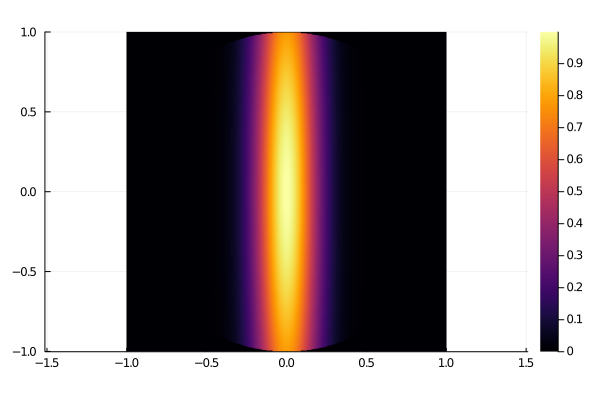

In [11]:
plot(heatmap(xx, yy, samples2), cm=:ice, aspectratio=true)

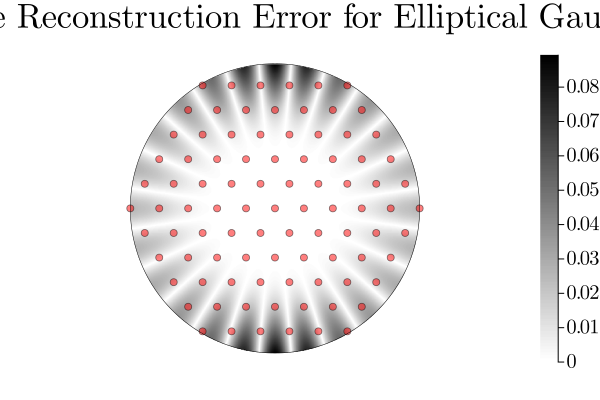

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [14]:
using LaTeXStrings
scalefontsizes(1.3)
scalefontsizes(1.3)
amp = 1
max = maximum(amp*abs.(samples-samples2))
p = palette([:white, :black], 100)
plot(heatmap(xx, yy, amp*abs.(samples-samples2), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Elliptical Gaussian}", fontfamily="Computer Modern")
p = palette([:white, :red], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=.5)
p = palette([:white, :black], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=0)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, fontfamily="Computer Modern")

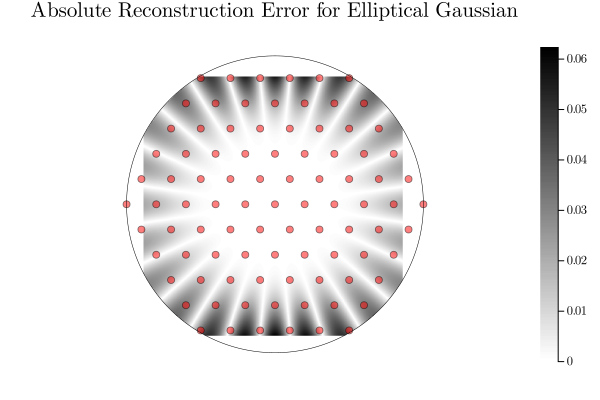

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [232]:
using LaTeXStrings
amp = 1
one = 30
two = 465
max = maximum(amp*abs.(samples-samples2)[one:two, one:two])
p = palette([:white, :black], 100)
plot(heatmap(xx[one:two], yy[one:two], amp*abs.(samples-samples2)[one:two, one:two], c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Elliptical Gaussian}", fontfamily="Computer Modern")
p = palette([:white, :red], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=.5)
p = palette([:white, :black], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=0)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, fontfamily="Computer Modern")

In [210]:
exp((-0^2/σ1^2-1^2/σ2^2)/2)

1.3887943864964021e-11

In [220]:
diff = [abs(gaussian(sqrt(a^2 + y[i]^2), atan(a, y[i])) - recon(sqrt(a^2 + y[i]^2), atan(a, y[i]))) for (i, a) in enumerate(x)]
m = maximum(diff)
findall(x->x==m, diff)

2-element Array{Int64,1}:
 58
 90

In [221]:
m

0.03497430536265296349171919321690472788681488558129383692443492514836430115971935

In [211]:
recon(sqrt(x[32]^2 + y[32]^2), atan(x[32]), y[32])

LoadError: MethodError: no method matching recon(::Float64, ::Float64, ::Float64)
Closest candidates are:
  recon(::Any, ::Any) at In[171]:1

In [207]:
gaussian(sqrt(x[32]^2 + y[32]^2), atan(y[32], x[32]))

0.7788007830714048

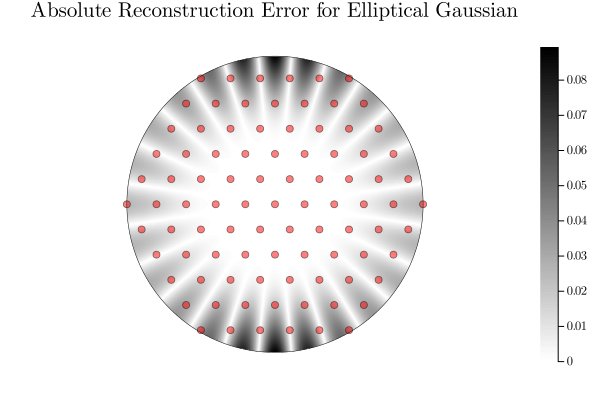

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [192]:
using LaTeXStrings
amp = 1
max = maximum(amp*abs.(samples-samples2))
p = palette([:white, :black], 100)
plot(heatmap(xx, yy, amp*abs.(samples-samples2), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Elliptical Gaussian}", fontfamily="Computer Modern")
p = palette([:white, :red], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=.5)
p = palette([:white, :black], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=0)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, fontfamily="Computer Modern")

In [191]:
max

0.0624067379343091871380030929871890404224261003872216011556513744348588894243092